<a href="https://colab.research.google.com/github/juancfaz/RecomendationMovieSystem/blob/main/RecomendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primer aproximación - JCFL

Paso 1: Importar las dependencias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Paso 2: Cargar la información

In [ ]:
ratings = pd.read_csv("ml-latest-small/ratings.csv")

In [ ]:
movies = pd.read_csv("ml-latest-small/movies.csv")

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Paso 3: Exploratory Data Analysis

In [ ]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


Distribución de calificaciones de películas

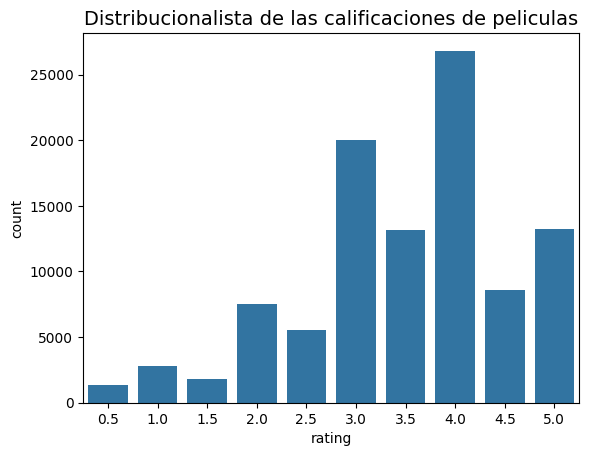

In [ ]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribucionalista de las calificaciones de peliculas", fontsize=14)
plt.show()

In [ ]:
print(f"Calificación global media: {round(ratings['rating'].mean(), 2)}.")

Calificación global media: 3.5.


In [ ]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Calificación media por usuario: {round(mean_ratings.mean(), 2)}.")

Calificación media por usuario: 3.66.


¿Qué películas son las más valoradas?

In [ ]:
ratings['movieId'].value_counts()

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
...,...
86279,1
86922,1
5962,1


In [ ]:
movies_ratings = ratings.merge(movies, on="movieId")
movies_ratings['title'].value_counts()[0:10]

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


¿Cuáles son las películas con las calificaciones más bajas y más altas?

In [ ]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()

movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [ ]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [ ]:
ratings[ratings['movieId'] == highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


# Promedio Bayesiano

El promedio bayesiano se utilizó para ajustar las calificaciones de las películas, considerando tanto la información previa como las opiniones de los usuarios. Fue útil para películas con pocas reseñas, ya que permite suavizar las calificaciones atípicas.

In [ ]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.head()

rating          
         count      mean
movieId                 
1          215  3.920930
2          110  3.431818
3           52  3.259615
4            7  2.357143
5           49  3.071429

In [ ]:
C = movie_stats['rating']['count'].mean()
m = movie_stats['rating']['mean'].mean()

print(f"Promedio de calificaciones por pelicula: {C:.2f}")
print(f"Calificación promedio por pelicula: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m + ratings.sum()) / (C + ratings.count())
    return bayesian_avg

Promedio de calificaciones por pelicula: 10.37
Calificación promedio por pelicula: 3.26


In [ ]:
lamerica = pd.Series([5,5])
print(f"El promedio de Lamerica fue: {round(bayesian_avg(lamerica), 2)}")

El promedio de Lamerica fue: 3.54


In [ ]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
bayesian_avg_ratings.head()

,movieId,bayesian_avg
0,1,3.890632
1,2,3.417227
2,3,3.260086
3,4,2.897612
4,5,3.104793


In [ ]:
movie_stats.head()

rating          
         count      mean
movieId                 
1          215  3.920930
2          110  3.431818
3           52  3.259615
4            7  2.357143
5           49  3.071429

In [ ]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.columns = ['rating_count', 'rating_mean']
movie_stats.head()

,rating_count,rating_mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [ ]:
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats.head()

,movieId,rating_count,rating_mean,bayesian_avg
0,1,215,3.920930,3.890632
1,2,110,3.431818,3.417227
2,3,52,3.259615,3.260086
3,4,7,2.357143,2.897612
4,5,49,3.071429,3.104793


Películas con la calificación más alta

In [ ]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values(by="bayesian_avg", ascending=False).head()

,movieId,rating_count,rating_mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Películas con la calificación más baja

In [ ]:
movie_stats.sort_values(by="bayesian_avg", ascending=True).head()

,movieId,rating_count,rating_mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


¿Cuántos géneros de películas hay?

In [ ]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
print(f"Hay {len(genre_frequency)} géneros de películas.")

Hay 20 géneros de películas.


In [ ]:
print("Los 3 géneros de películas más frecuentes son:")
for genre, frequency in genre_frequency.most_common(3):
    print(f"{genre}: {frequency} películas")

Los 3 géneros de películas más frecuentes son:
Drama: 4361 películas
Comedy: 3756 películas
Thriller: 1894 películas


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Adventure'),
  Text(1, 0, 'Animation'),
  Text(2, 0, 'Children'),
  Text(3, 0, 'Comedy'),
  Text(4, 0, 'Fantasy'),
  Text(5, 0, 'Romance'),
  Text(6, 0, 'Drama'),
  Text(7, 0, 'Action'),
  Text(8, 0, 'Crime'),
  Text(9, 0, 'Thriller'),
  Text(10, 0, 'Horror'),
  Text(11, 0, 'Mystery'),
  Text(12, 0, 'Sci-Fi'),
  Text(13, 0, 'War'),
  Text(14, 0, 'Musical'),
  Text(15, 0, 'Documentary'),
  Text(16, 0, 'IMAX'),
  Text(17, 0, 'Western'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

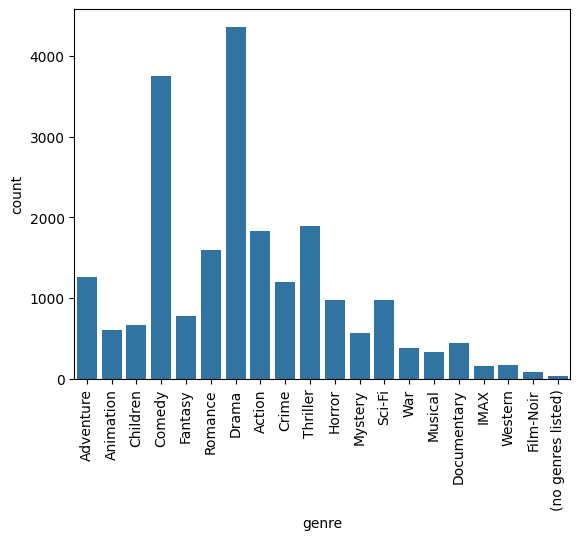

In [ ]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df)
plt.xticks(rotation=90)

# Paso 4: Preprocesamiento de los datos

La función `make_matrix()` crea una matriz dispersa que representa las calificaciones de usuarios a películas a partir de un DataFrame de calificaciones.

#### Parámetros
- **df**: DataFrame que contiene las calificaciones, donde:
  - `userId`: Identificador único del usuario.
  - `movieId`: Identificador único de la película.
  - `rating`: Calificación otorgada por el usuario a la película.

#### Proceso
1. **Conteo de Usuarios y Películas**: Se determina el número único de usuarios (M) y películas (N) en el DataFrame.
2. **Mapeo de IDs**:
   - Se crean diccionarios (`user_mapper` y `movie_mapper`) que asignan a cada `userId` y `movieId` un índice correspondiente en la matriz.
   - También se generan diccionarios inversos (`user_inv_mapper` y `movie_inv_mapper`) para la conversión de índices de vuelta a IDs.
3. **Indexación**: Se crea una lista de índices para usuarios y películas utilizando los mapeos creados.
4. **Construcción de la Matriz**: Se utiliza `csr_matrix` para construir una matriz dispersa utilizando las calificaciones y los índices de usuario y película.

#### Salida
- Retorna:
  - **X**: Matriz dispersa de calificaciones (usuarios x películas).
  - **user_mapper**: Mapeo de `userId` a índices.
  - **movie_mapper**: Mapeo de `movieId` a índices.
  - **user_inv_mapper**: Mapeo inverso de índices a `userId`.
  - **movie_inv_mapper**: Mapeo inverso de índices a `movieId`.

In [ ]:
from scipy.sparse import csr_matrix

def make_matrix(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = make_matrix(ratings)

In [ ]:
print(f"La matriz X tiene {X.shape[0]} usuarios y {X.shape[1]} películas.")

La matriz X tiene 610 usuarios y 9724 películas.


# Evaluación del sparsity

Lo utilizamos para indicar que tan llena esta la matriz que creamos anteriormente.

In [ ]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings / n_total
print(f"La matriz es {round(sparsity*100,2)}% escasa.")

La matriz es 1.7% escasa.


In [ ]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [ ]:
print(f"{n_ratings_per_user.max()}")
print(f"{n_ratings_per_user.min()}")

2698
20


In [ ]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [ ]:
print(f"{n_ratings_per_movie.max()}")
print(f"{n_ratings_per_movie.min()}")

329
1


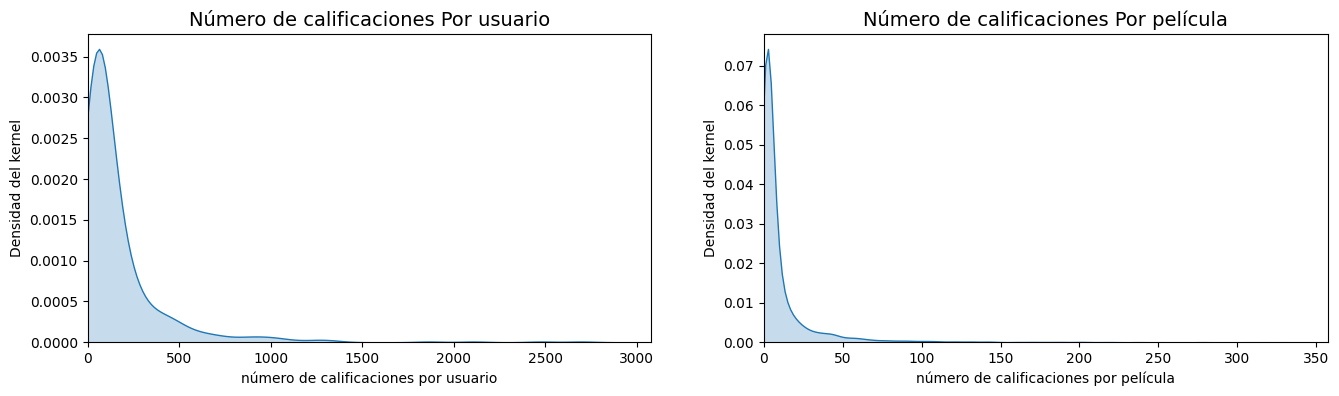

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Número de calificaciones Por usuario", fontsize=14)
plt.xlabel("número de calificaciones por usuario")
plt.ylabel("Densidad del kernel")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Número de calificaciones Por película", fontsize=14)
plt.xlabel("número de calificaciones por película")
plt.ylabel("Densidad del kernel")
plt.show()

# K-vecinos más cercanos

La función `find_similar_movies()` busca películas similares a una película dada utilizando el enfoque de vecinos más cercanos. A continuación se presenta un resumen de su funcionamiento:

### Parámetros
- **`movie_id`**: ID de la película de la cual se quieren encontrar similares.
- **`X`**: Matriz de características de las películas (en este caso, transpuesta).
- **`movie_mapper`**: Mapeo de IDs de películas a índices en `X`.
- **`movie_inv_mapper`**: Mapeo inverso de índices a IDs de películas.
- **`k`**: Número de películas similares que se desean encontrar.
- **`metric`**: Métrica para calcular la distancia (por defecto, 'cosine').

### Proceso
1. Se obtiene el índice de la película a partir de `movie_id`.
2. Se extrae el vector de características correspondiente a esa película.
3. Se inicializa un modelo de vecinos más cercanos utilizando la métrica especificada.
4. Se ajusta el modelo a la matriz de características.
5. Se busca el k-ésimo vecino más cercano a la película seleccionada.

### Salida
- Retorna una lista de IDs de las `k` películas más similares, excluyendo la propia película de entrada.


In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [ ]:
movies_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10)
movie_title = movies_titles[movie_id]

print(f"La película similar a {movie_title} son:\n")
for i in similar_movies:
    print(movies_titles[i])

La película similar a Toy Story (1995) son:

Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


Probemos con tras metricas

In [ ]:
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k=10, metric='manhattan')
movie_title = movies_titles[movie_id]

print(f"La película similar a {movie_title} son:\n")
for i in similar_movies:
    print(movies_titles[i])

La película similar a Toy Story (1995) son:

Toy Story 2 (1999)
Bug's Life, A (1998)
Groundhog Day (1993)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Mission: Impossible (1996)
Babe (1995)
Monsters, Inc. (2001)
Toy Story 3 (2010)


# Paso 6: Problema del arranque frio

Anteriormente aplicamos un filtrado colaborativo basado en usuarios e ítems (peliculas) pero esto puede ser un problema porque los usuarios o ítems nuevos, que no tienen suficientes interacciones previas, no pueden ser recomendados.

Para resolverlo aplicaremos un filtrado basado en contenido. Este enfoque no depende tanto de las interacciones pasadas entre usuarios e ítems, sino que hace recomendaciones basadas en las características de los usuarios y los ítems.

In [ ]:
n_movies = movies['movieId'].nunique()
print(f"Hay {n_movies} películas en el conjunto de datos.")

Hay 9742 películas en el conjunto de datos.


In [ ]:
genres = set(g for genres in movies['genres'] for g in genres)

for g in genres:
    movies[g] = movies['genres'].apply(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title', 'genres'])

In [ ]:
movie_genres.head()

,Thriller,Mystery,Romance,Film-Noir,Horror,Children,Documentary,Sci-Fi,Western,Fantasy,Animation,Crime,IMAX,Drama,(no genres listed),Musical,Action,Comedy,Adventure,War
0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


La matriz debe ser cuadrada ya que se esta comparando cada película con todas las demas.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"La matriz de similitud coseno tiene una forma de: {cosine_sim.shape}")

La matriz de similitud coseno tiene una forma de: (9742, 9742)


In [ ]:
from fuzzywuzzy import process

def movie_finder(title):
      all_titles = movies['title'].tolist()
      closest_match = process.extractOne(title, all_titles)
      return closest_match[0]

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
title = movie_finder("jumanji")
title

'Jumanji (1995)'

In [ ]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Titulo: {title}")
print(f"Index: {idx}")

Titulo: Jumanji (1995)
Index: 1


In [ ]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
sim_scores

[(53, 1.0000000000000002),
 (109, 1.0000000000000002),
 (767, 1.0000000000000002),
 (1514, 1.0000000000000002),
 (1556, 1.0000000000000002),
 (1617, 1.0000000000000002),
 (1618, 1.0000000000000002),
 (1799, 1.0000000000000002),
 (3574, 1.0000000000000002),
 (6075, 1.0000000000000002)]

In [ ]:
similar_movies = [i[0] for i in sim_scores]
similar_movies

[53, 109, 767, 1514, 1556, 1617, 1618, 1799, 3574, 6075]

In [ ]:
print(f"Películas similares a {title}:\n")
movies['title'].iloc[similar_movies]

Películas similares a Jumanji (1995):



,title
53,"Indian in the Cupboard, The (1995)"
109,"NeverEnding Story III, The (1994)"
767,Escape to Witch Mountain (1975)
1514,Darby O'Gill and the Little People (1959)
1556,Return to Oz (1985)
1617,"NeverEnding Story, The (1984)"
1618,"NeverEnding Story II: The Next Chapter, The (1..."
1799,Santa Claus: The Movie (1985)
3574,Harry Potter and the Sorcerer's Stone (a.k.a. ...
6075,"Chronicles of Narnia: The Lion, the Witch and ..."


In [ ]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    return movies['title'].iloc[similar_movies]

In [ ]:
get_content_based_recommendations("toy story", n_recommendations=5)

,title
1706,Antz (1998)
2355,Toy Story 2 (1999)
2809,"Adventures of Rocky and Bullwinkle, The (2000)"
3000,"Emperor's New Groove, The (2000)"
3568,"Monsters, Inc. (2001)"


# Paso 7: Reducción de la dimensionalidad con factorización matricial

Al descomponer una matriz muy grande (de usuarios e ítems) en matrices más pequeñas, el sistema puede hacer recomendaciones más eficientes y precisas asi mejorando la generalización.

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10, random_state=42)
Q = svd.fit_transform(X.T)
Q.shape

(9724, 20)

In [ ]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, metric="cosine", k=10)
movie_title = movies_titles[movie_id]

print(f"Películas similares a {movie_title}:\n")
for i in similar_movies:
    print(movies_titles[i])
#

Películas similares a Toy Story (1995):

Home Alone (1990)
Jurassic Park (1993)
Aladdin (1992)
Back to the Future (1985)
Forrest Gump (1994)
Willy Wonka & the Chocolate Factory (1971)
Groundhog Day (1993)
Star Wars: Episode IV - A New Hope (1977)
Princess Bride, The (1987)
